In [1]:
from libs.corp_df import *
from tqdm.auto import tqdm
from libs.get_docs import get_pickled_docs as gpd
from libs.dim_red import *
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
import seaborn as sns

In [2]:
# retrieve documents
print('Retrieving Documents...')
cdir = 'corpora/articles_stage2.pickle'
docs = gpd(cdir, verbose=True)

Retrieving Documents...
TIME ELAPSED: 29.22s


In [3]:
roots_raw = []
print('getting raw roots...')
for doc in tqdm(docs):
    for pg in doc:
        for sent in pg:
            for tok in sent:
                for lem in tok:
                    if lem.pos_tag in ['VB', 'BN', 'BNT']:
                        if lem.shoresh is not None:
                            roots_raw.append(lem.shoresh)
                            
# filter by minimum # occurrences
print('filtering...')
valid_roots = set([i for i in tqdm(roots_raw) if roots_raw.count(i) > 29])
print(len(valid_roots))

getting raw roots...


  0%|          | 0/524 [00:00<?, ?it/s]

filtering...


  0%|          | 0/26165 [00:00<?, ?it/s]

226


In [4]:
# select random roots
NUM_ROOTS = 5

# randomly chosen roots
slct_roots = random.sample(valid_roots, NUM_ROOTS)
print(slct_roots)

['אשם', 'כלל', 'צפה', 'שנה', 'בין']


In [5]:
isUNK = lambda tkn: 1 if tkn.tokenizer_index == 1 else 0

# make df dictionary
cats = ['lemma', 'root', 'binyan', 'is_unk', 'raw_embedding']
dfdict = {cat: [] for cat in cats}
# get info
for doc in tqdm(docs):
    for pg in doc:
        for sent in pg:
            for tok in sent:
                for lem in tok:
                    if lem.shoresh in slct_roots:
                        # get metadata
                        dfdict['lemma'].append(lem.lemma)
                        dfdict['root'].append(lem.shoresh)
                        dfdict['binyan'].append(lem.binyan)
                        
                        unk = isUNK(tok)
                        dfdict['is_unk'].append(unk)
                        
                        # get embeddings
                        dfdict['raw_embedding'].append(tok.embedding)
                        
df = pd.DataFrame(dfdict)
print(len(df))
df = df[df['is_unk'] == 0]
print(len(df))

  0%|          | 0/524 [00:00<?, ?it/s]

452
392


In [6]:
for i in tqdm(range(12)):
    print('extracting embeddings from layer {}...'.format(i))
    layer_embedding = [e[i].numpy() for e in df['raw_embedding']]
    print('reducing to 2 dimensions via t-SNE...')
    x, y = tsne(layer_embedding, n_components=2, verbose=True)
    print('adding to dataframe...')
    df['x_' + str(i)] = x
    df['y_' + str(i)] = y
    print()

  0%|          | 0/12 [00:00<?, ?it/s]

extracting embeddings from layer 0...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 0.98
adding to dataframe...

extracting embeddings from layer 1...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 1.05
adding to dataframe...

extracting embeddings from layer 2...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 1.11
adding to dataframe...

extracting embeddings from layer 3...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 0.9
adding to dataframe...

extracting embeddings from layer 4...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 0.97
adding to dataframe...

extracting embeddings from layer 5...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 0.93
adding to dataframe...

extracting embeddings from layer 6...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 0.94
adding to dataframe...

extracting embeddings from layer 7...
reducing to 2 dimensions via t-SNE...
TIME ELAPSED: 0.95
adding to dataframe...

extracting embeddings from layer 8...
reducing to

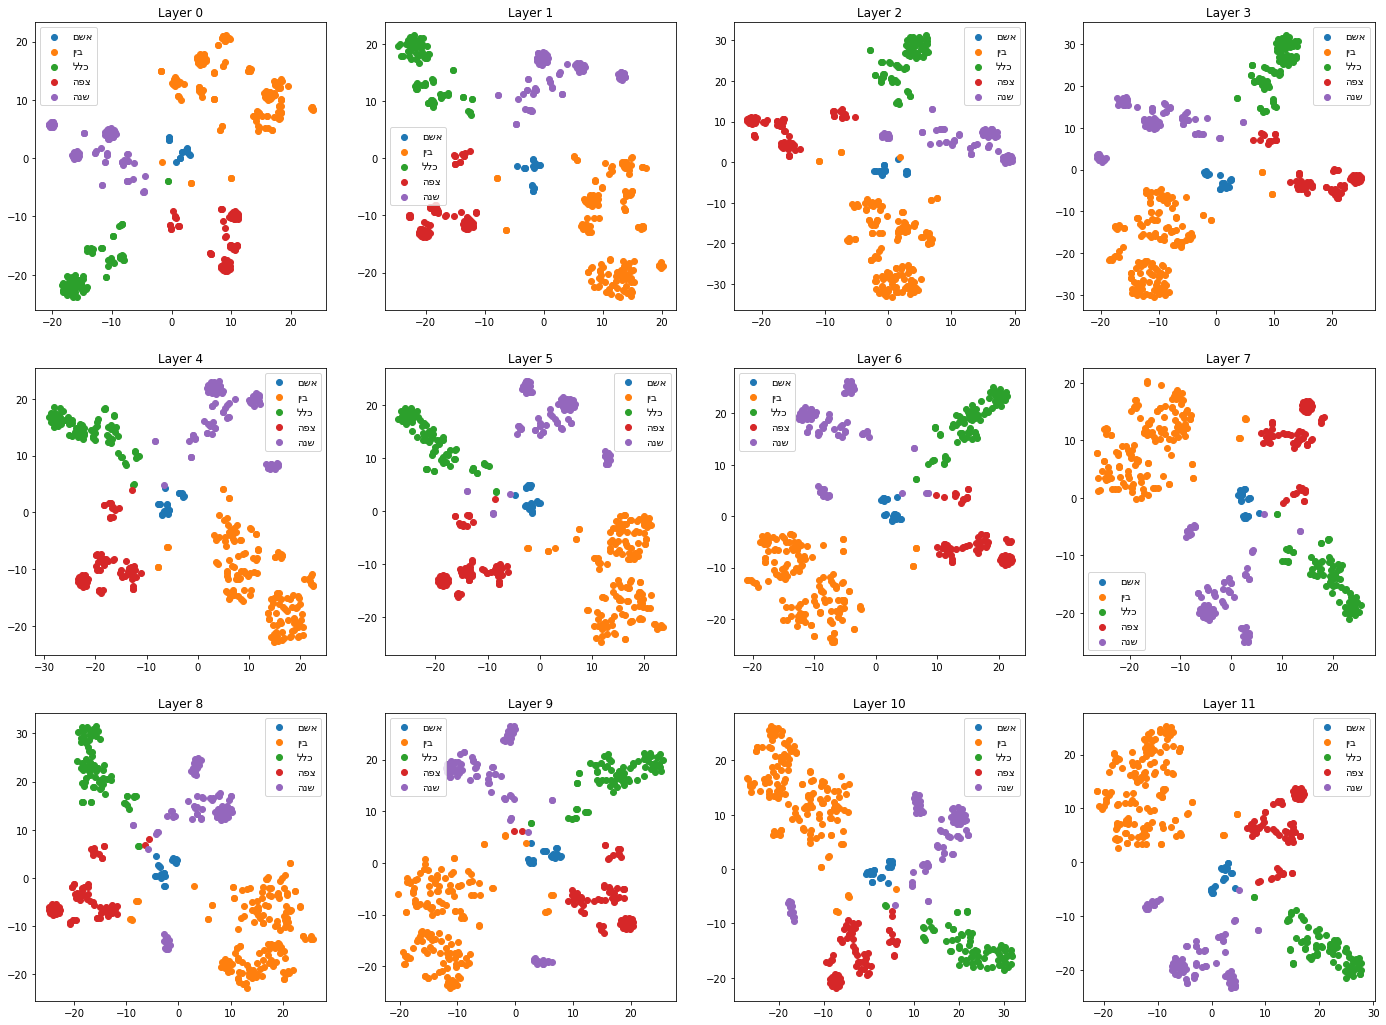

In [7]:
def getxylabs(layer):
    l = str(layer)
    return 'x_' + l, 'y_' + l

fig, axes = plt.subplots(3, 4, figsize=(24,18))

for layer, ax in zip(range(12), axes.reshape(-1)):
    for cat, dff in df.groupby('root'):
        x, y = getxylabs(layer)
        ax.scatter(dff[x], dff[y], label=cat[::-1])
    
    ax.set_title('Layer {}'.format(layer))
    ax.legend()
    
# plt.savefig('photos/by_layer_no_filter.png')
        
plt.show()